<a href="https://colab.research.google.com/github/judeha/hodpQguide/blob/main/HODP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
path = ('/content/drive/My Drive/HUMIC/q-scores.csv')
data = pd.read_csv(path)

In [49]:
# 1. CLEAN DATA

# Remove Duplicated Columns 
data = data.drop_duplicates(subset=['Comments'])

# Remove NA
data = data.dropna()

# Remove rows with "None" in "Workload Mean" column
for x in data.index:
  if data.loc[x, 'Workload Mean']=='None':
    data.drop(x, inplace=True)


# Change values from strings to numeric
cols=['Workload Mean', ' Workload Standard Deviation', 'Rating', 'Recommendation Rating']
data[cols] = data[cols].apply(pd.to_numeric)

In [11]:
print(data.columns.values)

['Semester' 'Department' 'Course Title' 'Workload Mean'
 ' Workload Standard Deviation' 'Rating' 'Enrollment'
 'Recommendation Rating' 'Comments']


In [5]:
# 2. EXPLORATORY ANALYSIS
from numpy import ravel_multi_index

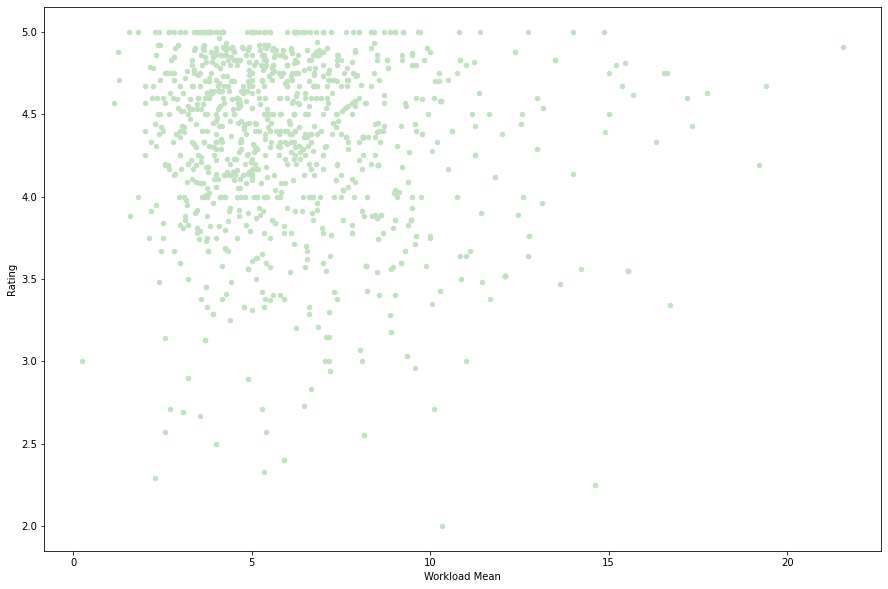

In [6]:
# Plotting workload versus rating
data.plot(kind='scatter',
          x='Workload Mean',
          y='Rating',
          color='#C1E1C1', # pastel green
          figsize=(15,10))

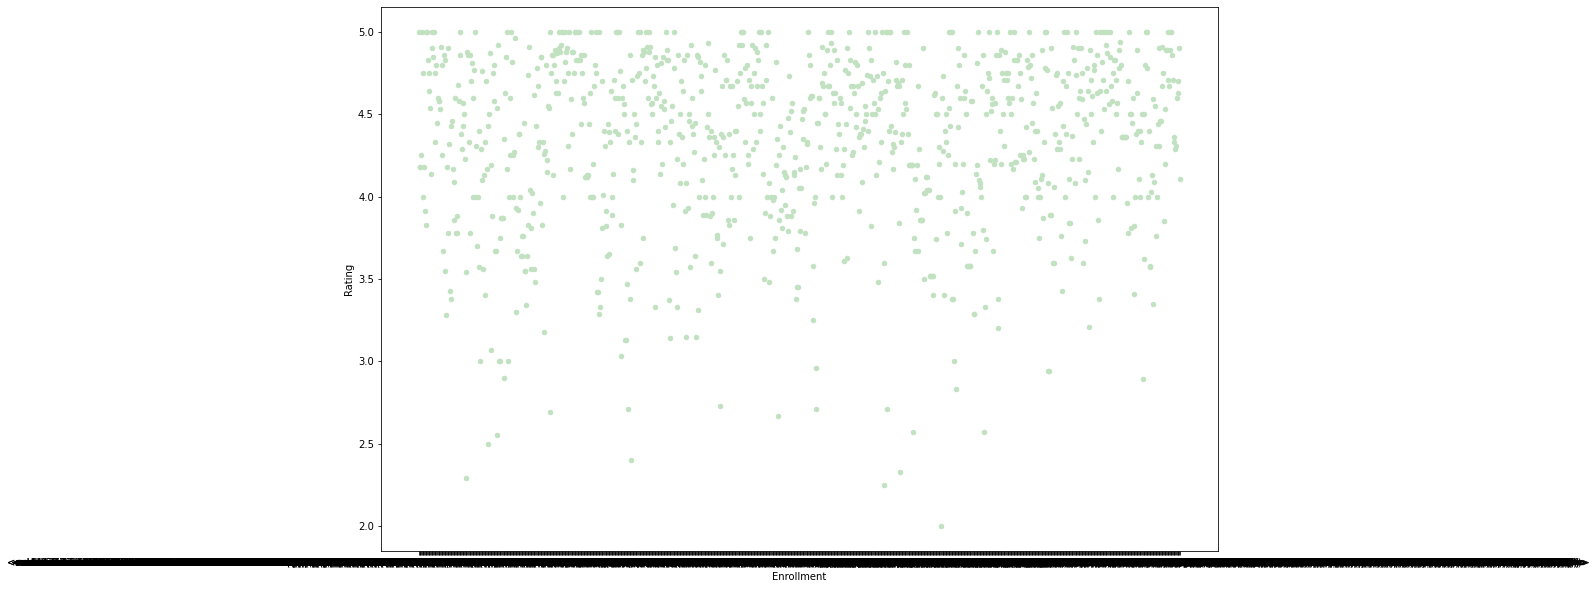

In [7]:
# Plotting workload versus rating
data.plot(kind='scatter',
          x='Enrollment',
          y='Rating',
          color='#C1E1C1', # pastel green
          figsize=(15,10))

In [8]:
# Group statistics by department
def group(dataset, statistic):
  # Find mean by department
  groupedMean = dataset.groupby('Department')[statistic].mean()

  # Convert from series to df
  groupedMean = groupedMean.to_frame()

  # Sort in descending order
  sorted = groupedMean.sort_values([statistic], ascending=False)
  return sorted

In [15]:
# Get ratings by department
ratingsDept = group(data, 'Rating')

# Get workload by department
workloadDept = group(data, 'Workload Mean') 

# NOTE: unsure why unable to group for 'Enrollment'

In [16]:
# Plot function for ratings and workload
def plotting(dataset):
  dataset.plot(kind='bar', figsize=(15,10), color='#C1E1C1')

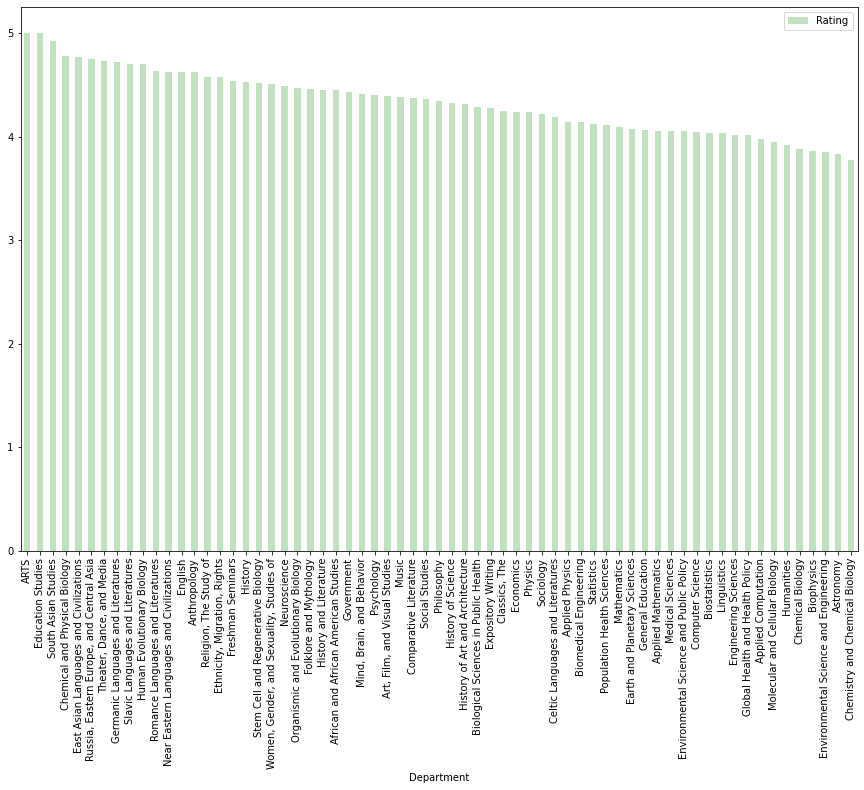

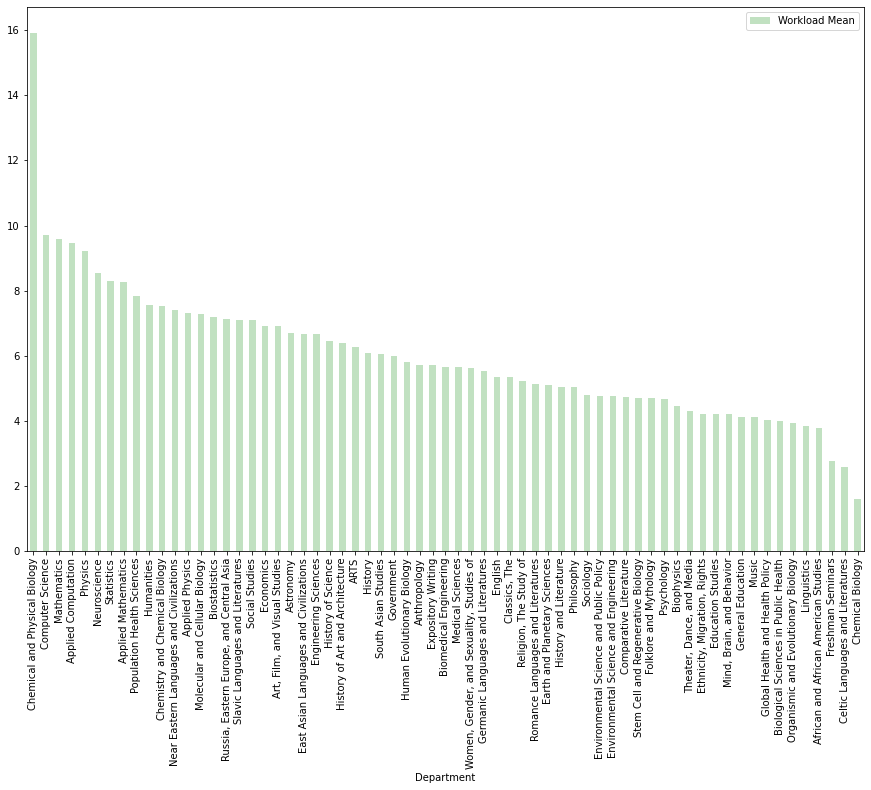

In [17]:
# Plot ratings and workload by department
plotting(ratingsDept)
plotting(workloadDept)

In [ ]:
# 3. SENTIMENT ANALYSIS

# Import dependencies
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stemmer = PorterStemmer()
stop = stopwords.words('english')

In [34]:
# 3A. PREPROCESSING
# normalize text cases
def normalizeCase(text):
  return text.lower()

# remove special characters
def removeChars(text):
  return re.sub(r'[^a-zA-Z]', ' ',text)

# remove stopwords
def removeStop(textLst):
  for word in textLst:
    if word in stop: textLst.remove(word)
  return textLst

# stemming
def stem(word):
  return stemmer.stem(word)

# tokenize
def tokenize(text):
  return nltk.word_tokenize(text)

# tag parts of speech
def tagPos(textLst):
  return nltk.pos_tag(textLst)

In [35]:
# complete cleaning function
def clean(text):
  
  text = removeChars(normalizeCase(text))
  
  lst = list(text)
  removed = removeStop(lst)

  for word in removed:
    word = stem(word)

  joined = ''.join(removed)

  return tagPos(tokenize(joined))

In [37]:
def cleanLst(lst):
  for text in lst:
    text = clean(text)
  return lst

In [ ]:
for index,row in data.iterrows():
  comments = data.loc[index, 'Comments']
  comments = cleanLst(comments)

In [66]:
# 3B. SENTIMENT ANALYSIS

# install dependencies
!pip install textblob
from textblob import TextBlob

In [67]:
# gets polarity, or how positive/negative a review is from -1 to 1
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [80]:
# gets subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

In [98]:
# sentiment analysis function, this one only looks at aggregate polarity/subjectivity for each course, not for each indiv comment
def getMeanSentiment(commentLst):
  mean_sub=getSubjectivity(commentLst)
  mean_pol=getPolarity(commentLst)
  return[mean_pol, mean_sub]

In [ ]:
# run analysis for each course
# may need to create new col called subjectivity and polarity beforehand
for index,row in data.iterrows():
  print(index)
  comments = data.loc[index, 'Comments']
  result = getMeanSentiment(comments)
  data.loc[index,'Polarity'] = result[0]
  data.loc[index,'Subjectivity'] = result[1]

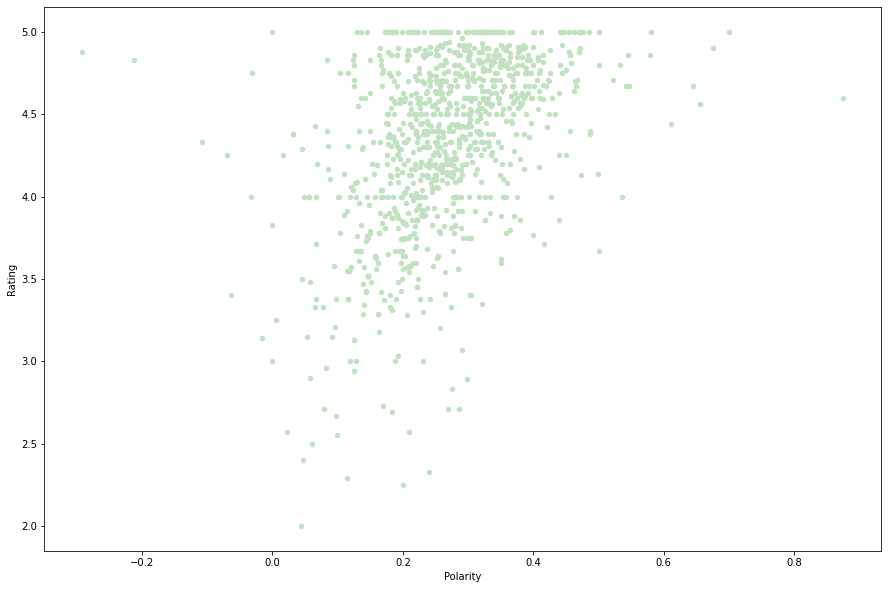

In [106]:
# Plot polarity versus rating
data.plot(kind='scatter',
          x='Polarity',
          y='Rating',
          color='#C1E1C1', # pastel green
          figsize=(15,10))

In [104]:
# Get polarity by department
polarityDept = group(data, 'Polarity')

# Get subjectivity by department
subjDept = group(data, 'Subjectivity')

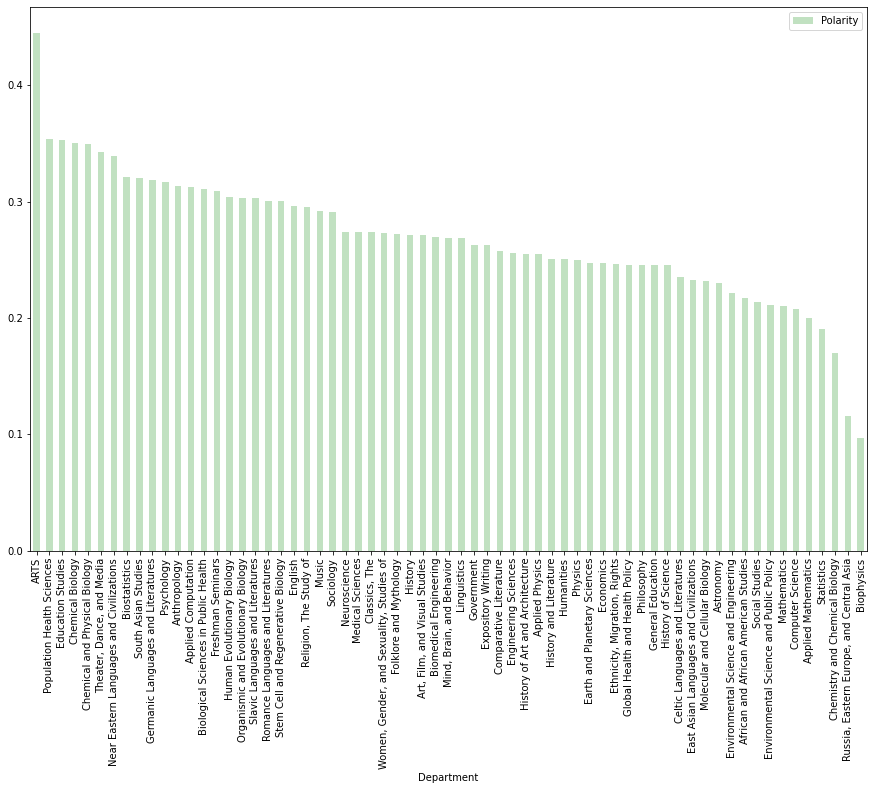

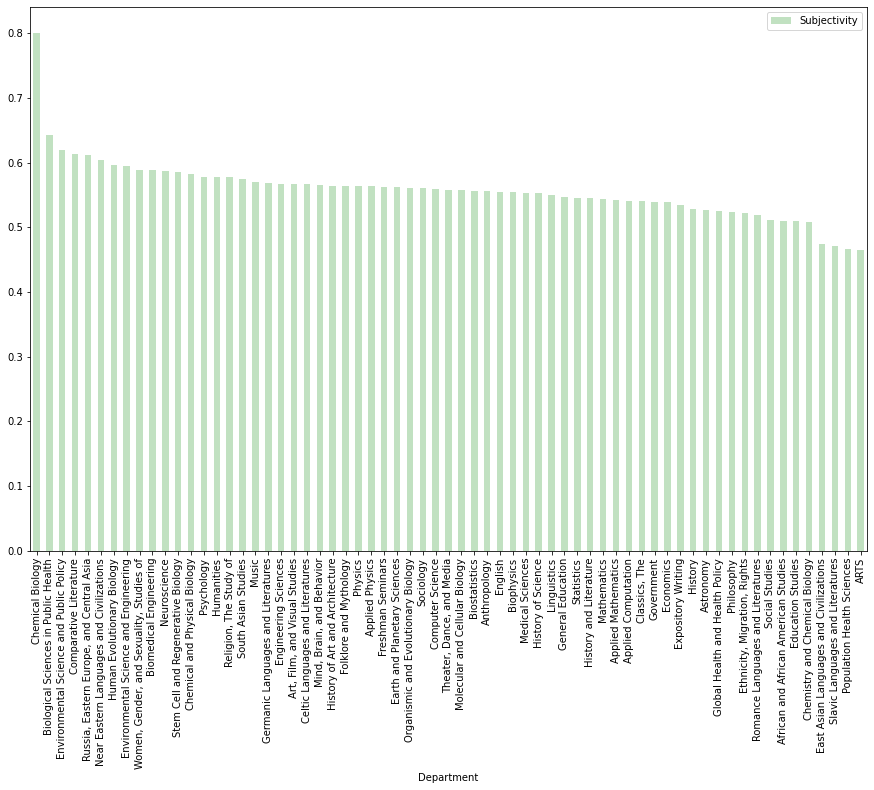

In [105]:
# Plot polarity and subjectivity by department
plotting(polarityDept)
plotting(subjDept)